# This notebook test several score matching methods

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from jax.scipy.stats.multivariate_normal import pdf as jax_normal_pdf
from functools import partial
import optax

import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("")))
from sampling_utlis import ula
from score_matching_utlis import score_matching_loss, sliced_score_matching_loss
from model.model import Score_MLP

### Build target distribution and sample from it

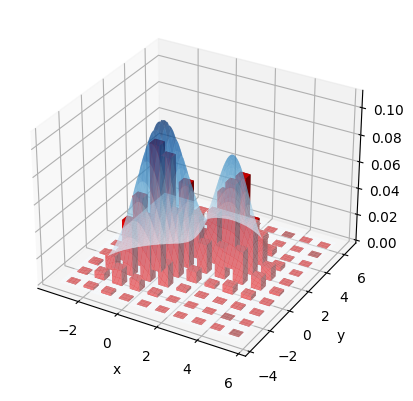

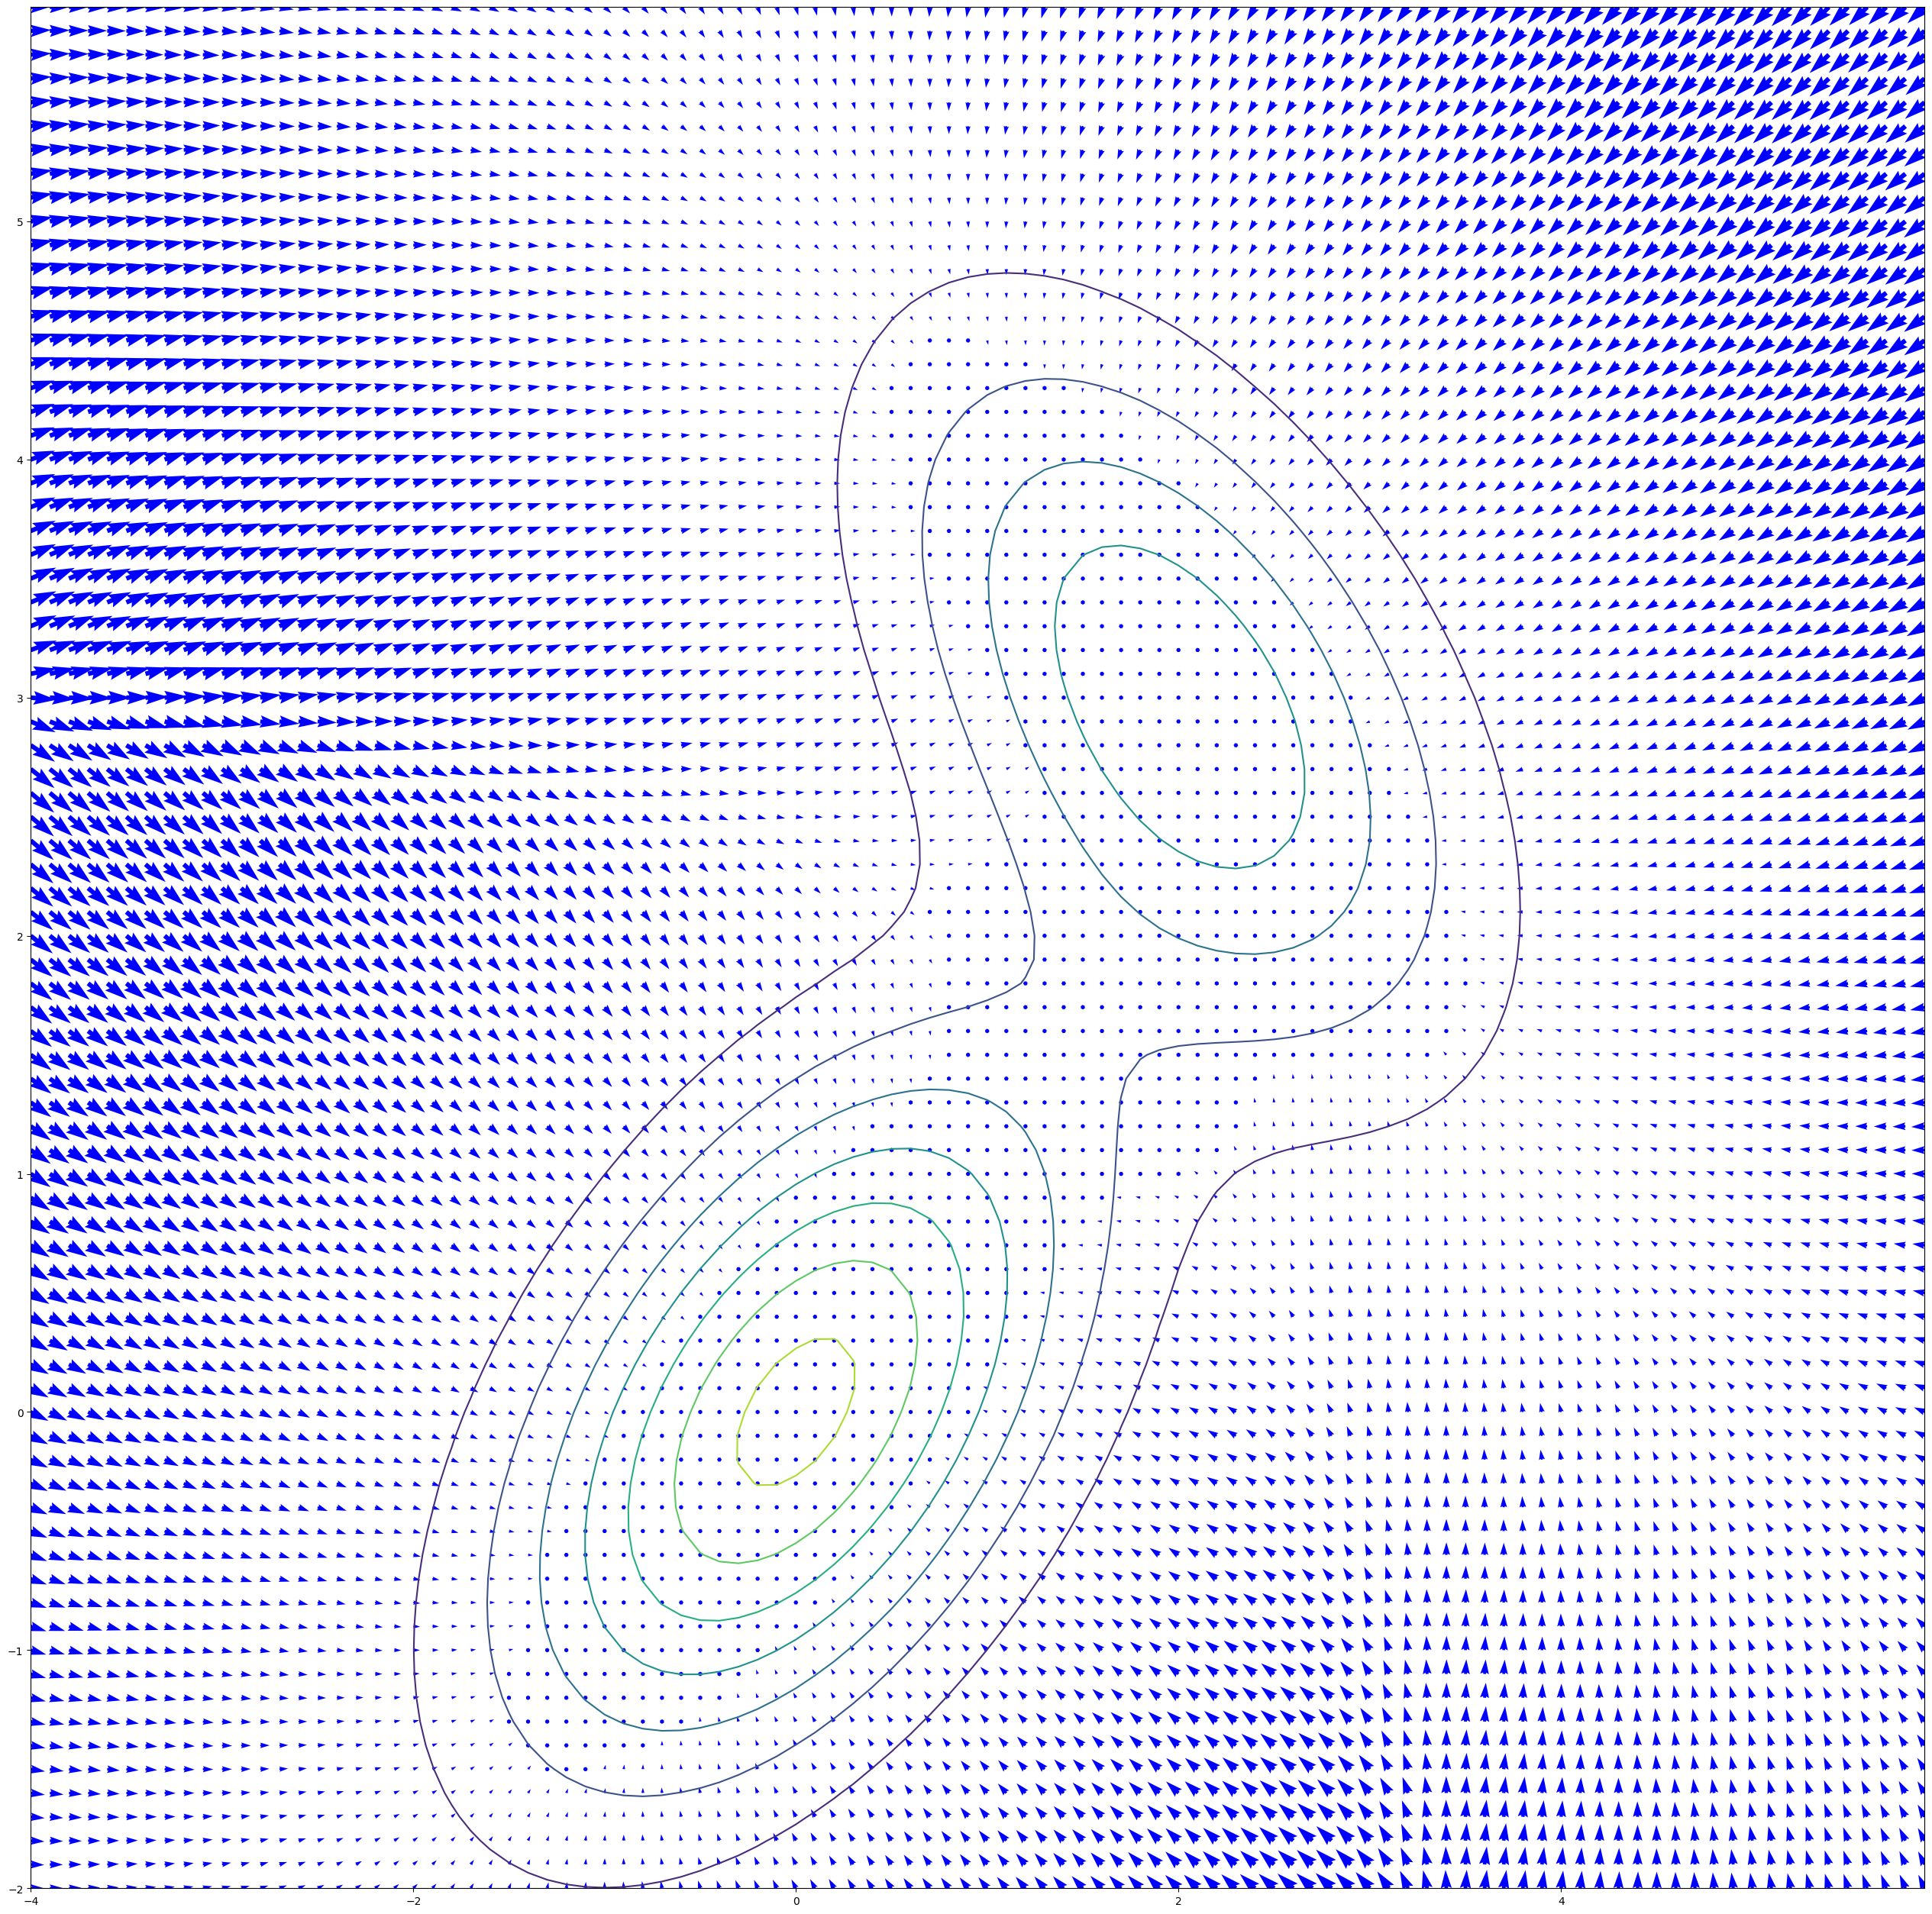

In [2]:
# Define parameters for the mixture of 2D Gaussians
means = np.array([[0, 0], [2, 3]])  # Means of the Gaussians
covs = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])  # Covariance matrices of the Gaussians
weights = [0.6, 0.4]  # Weights of the Gaussians (sums to 1)

# Define target distribution
@jax.jit
def target_pdf(x):
    return jnp.sum(jnp.array([jax_normal_pdf(x, mean=mean, cov=cov) * weight for (mean, cov, weight) in zip(means, covs, weights)]))

def log_target_pdf(x):
    return jnp.log(target_pdf(x))

target_score = jax.jit(jax.jacobian(log_target_pdf))

# Generate samples from the mixture of 2D Gaussians
def generate_samples_2d(n_samples):
    component_choices = np.random.choice(len(means), size=n_samples, p=weights)
    samples = np.zeros((n_samples, 2))
    for i in range(len(means)):
        mask = (component_choices == i)
        samples[mask] = multivariate_normal.rvs(mean=means[i], cov=covs[i], size=np.sum(mask))
    return samples

# Example: Generate 1000 samples from the mixture of 2D Gaussians
samples = generate_samples_2d(10000)

# Plot histogram
def plot_histogram(x, y, density_func=target_pdf):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, density=True)

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)

    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color="red")

    # Compute the density surface
    X, Y = np.meshgrid(np.arange(xedges[0], xedges[-1], 0.01), np.arange(yedges[0], yedges[-1], 0.01))
    densities = jax.vmap(density_func)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)

    ax.plot_surface(X, Y, densities, cmap=cm.Blues, alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

def plot_score(x, y, score_func=target_score, pdf_func=target_pdf, learned_score_func=None):
    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot()
    X, Y = np.meshgrid(x,y)

    # Construct score plot
    scores = jax.vmap(score_func)(np.stack([X.ravel(), Y.ravel()], axis=1))
    dX = scores[:,0].reshape(X.shape)
    dY = scores[:,1].reshape(Y.shape)
    ax.quiver(X, Y, dX, dY, color='b')

    if learned_score_func:
        learned_scores = jax.vmap(learned_score_func)(np.stack([X.ravel(), Y.ravel()], axis=1))
        dX = learned_scores[:,0].reshape(X.shape)
        dY = learned_scores[:,1].reshape(Y.shape)
        ax.quiver(X, Y, dX, dY, color='r')

    # Construct density plot
    pdfs = jax.vmap(pdf_func)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)
    ax.contour(X, Y, pdfs)

plot_histogram(samples[:,0], samples[:,1])
plot_score(np.arange(-4, 6, 0.1), np.arange(-2, 6, 0.1))
plt.show()

### Generate sample use true score function

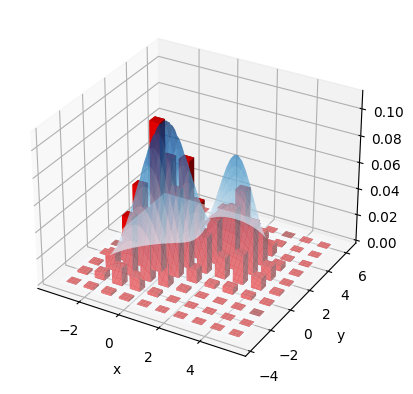

In [3]:
@jax.jit
def score_fn(x, t): 
    return target_score(x)

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=10000)
random_keys = jax.random.split(random_key, 10000)

ula_wrapped = partial(ula, score_fn, T=10, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

plot_histogram(samples[:,0], samples[:,1])
plt.show()

### Use the samples to learn the score function

In [4]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*3, dim=2)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, np.zeros(2), 0)
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(score_matching_loss, model.apply)

In [5]:
# Estimate the lower bound for score matching loss
# The lower bound loss is given by -1/2 E [ \|true_score(X)\|_2^2 ]
expected_loss_lower_bound = -jnp.mean(jnp.sum(jax.vmap(target_score)(generate_samples_2d(10000))**2, axis=1))/2
print("The expecated score matching loss lower bound is:", expected_loss_lower_bound)

NameError: name 'target_score' is not defined

In [6]:
@jax.jit
def params_update(param, optimizer_state, xs):
    ts = jnp.zeros(xs.shape[0])
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for i in range(10000):
    # get a batch of data
    xs = generate_samples_2d(1024)
    # one step grad update
    loss, model_param, optimizer_state = params_update(model_param, optimizer_state, xs)
    losses.append(loss)
    if (i+1) % 1000 == 0:
        print(f"iter:{i+1}, loss:{loss}")

2024-04-13 22:33:09.676874: W external/xla/xla/service/gpu/ir_emitter_triton.cc:761] Shared memory size limit exceeded.


iter:1000, loss:-1.1213767528533936
iter:2000, loss:-1.1952828168869019
iter:3000, loss:-1.1644014120101929
iter:4000, loss:-1.2030302286148071
iter:5000, loss:-1.1319224834442139
iter:6000, loss:-1.1330680847167969
iter:7000, loss:-1.1033940315246582
iter:8000, loss:-1.128536581993103
iter:9000, loss:-1.24937105178833
iter:10000, loss:-1.1248986721038818


[]

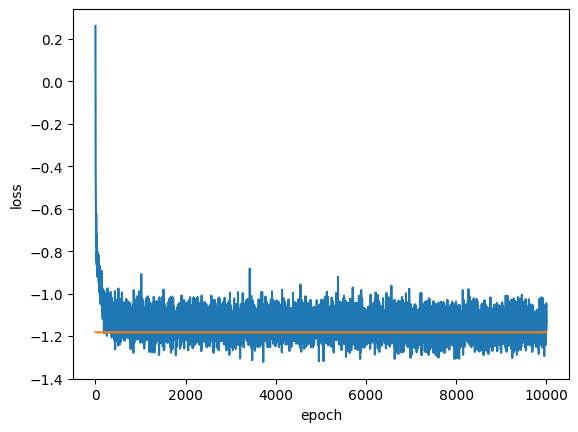

In [7]:
plt.figure()
plt.plot(losses, label="training loss")
plt.plot([expected_loss_lower_bound]*len(losses), label="expected lower bound")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

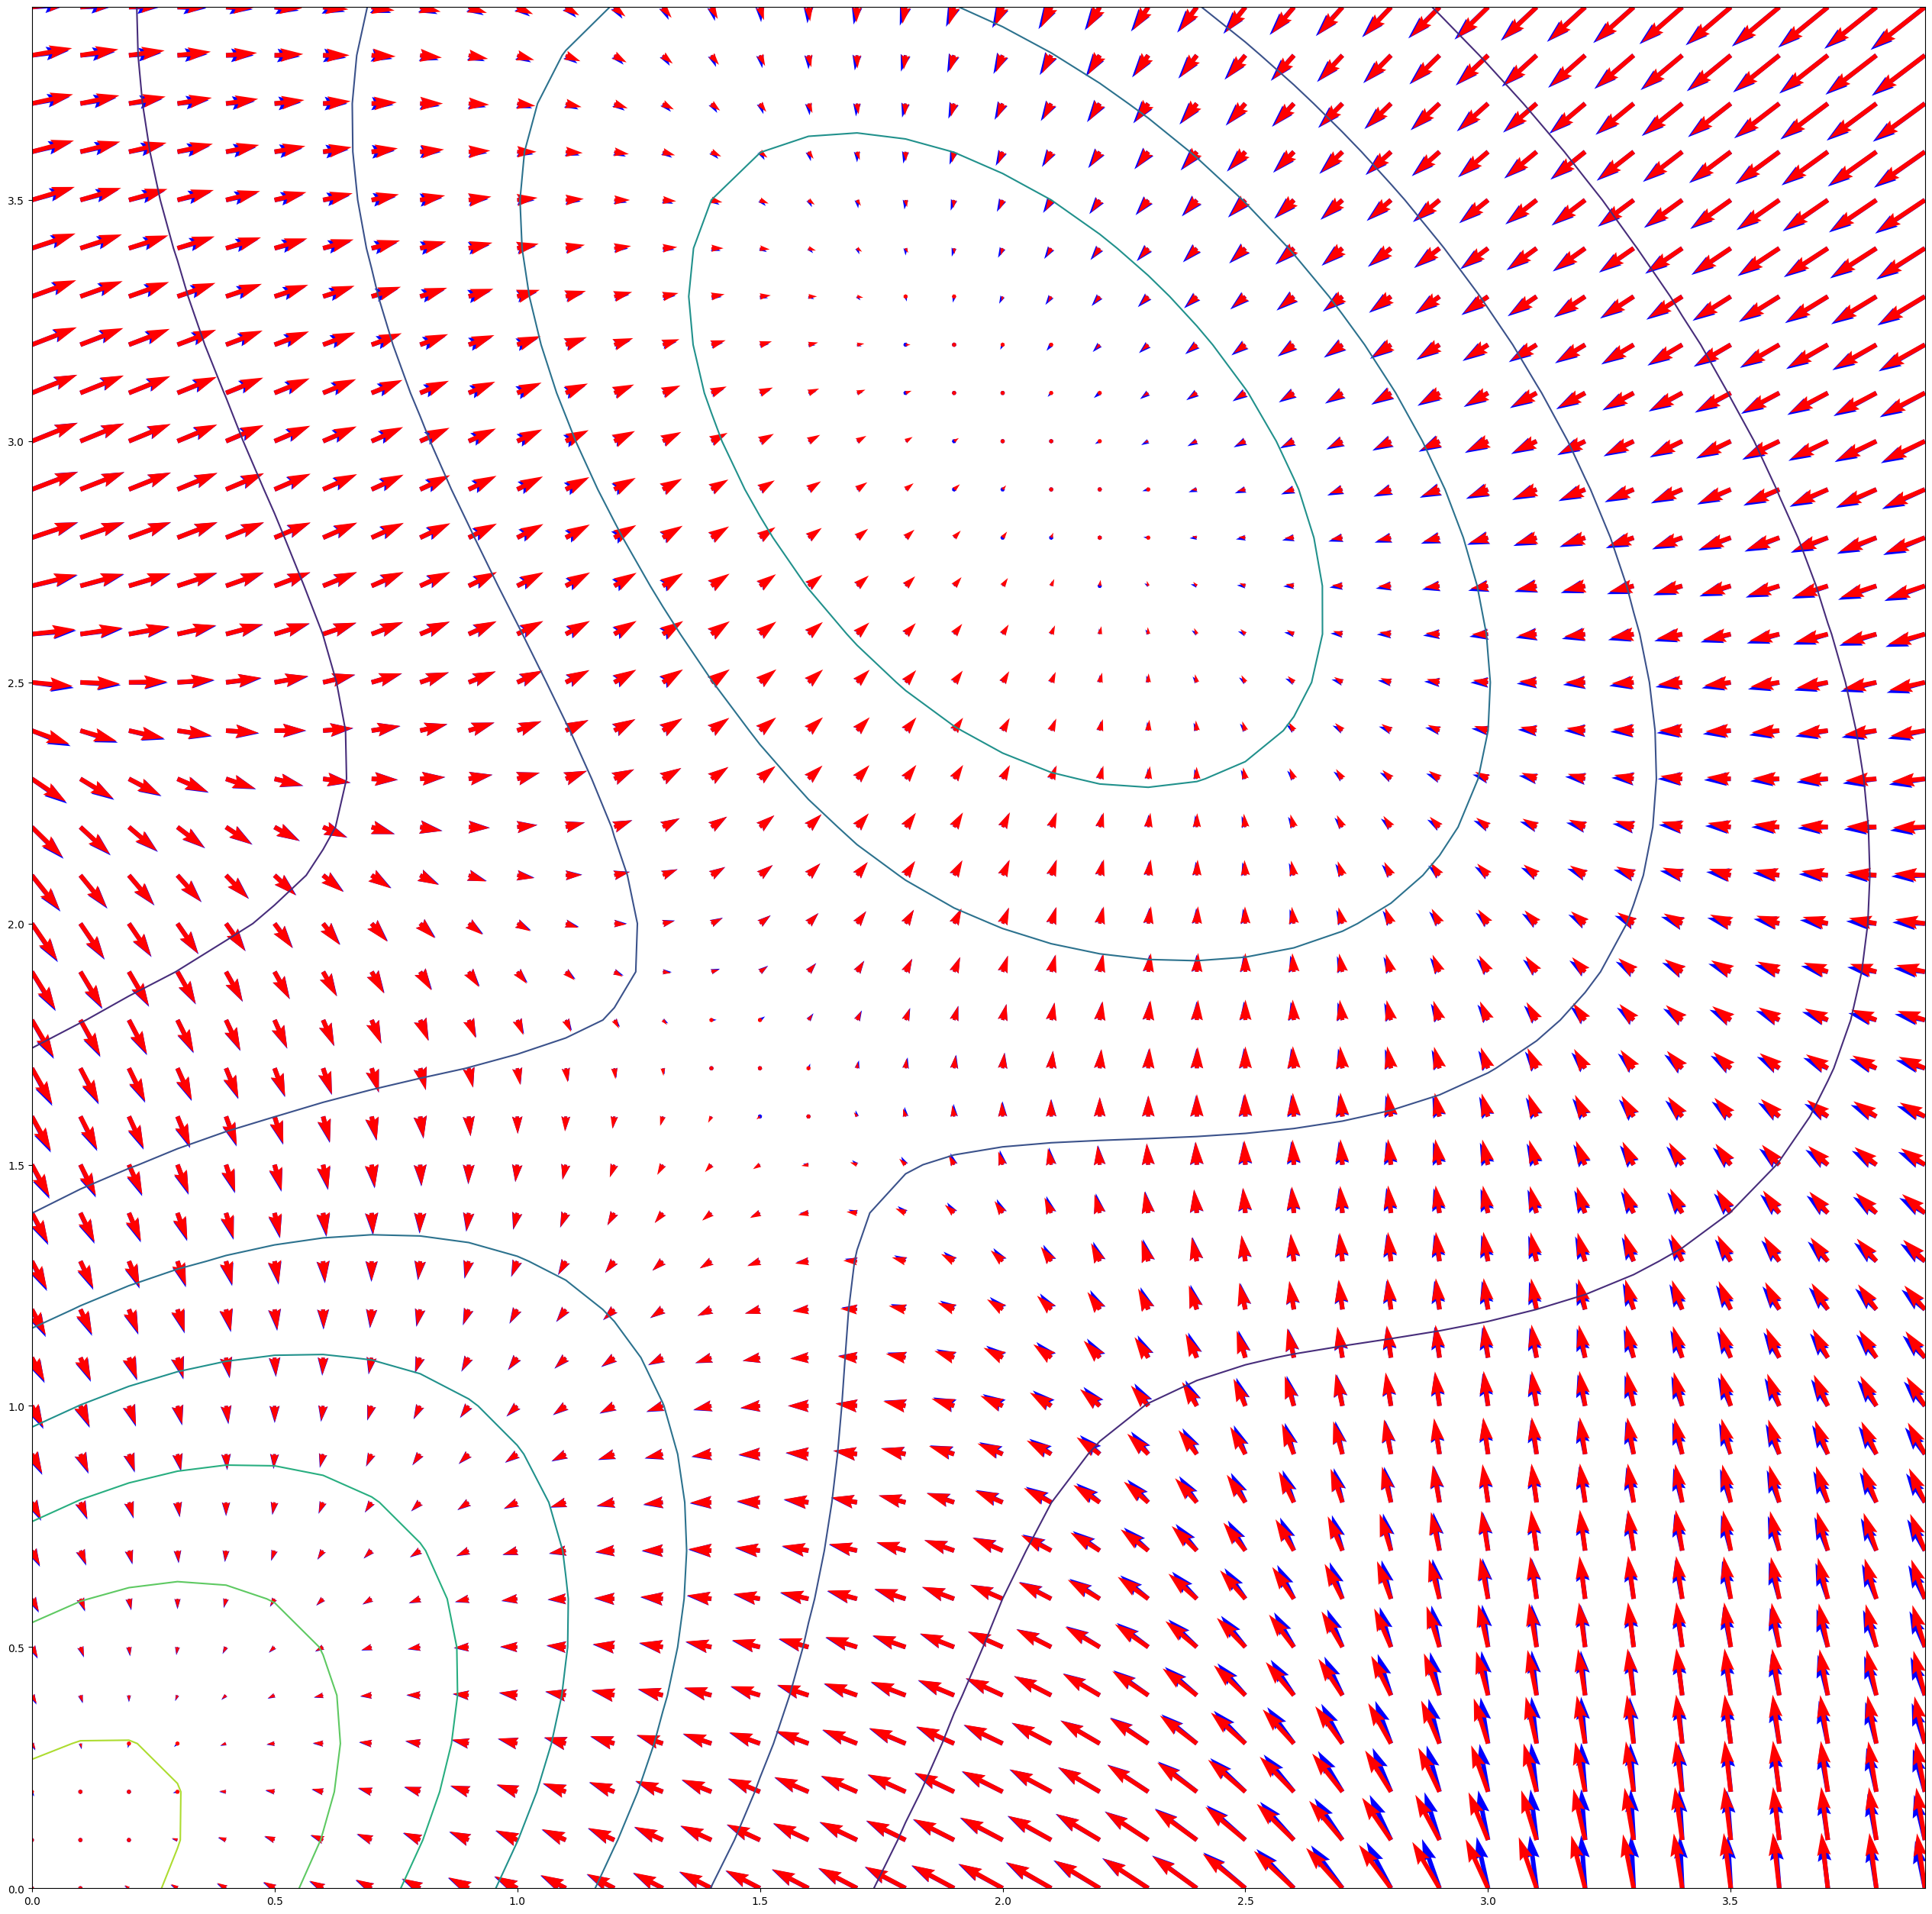

In [8]:
def learned_score_fn(x):
    return model.apply(model_param, x, 0)

plot_score(np.arange(0, 4, 0.1), np.arange(0, 4, 0.1), learned_score_func=learned_score_fn)

### Generate sample use learned score function

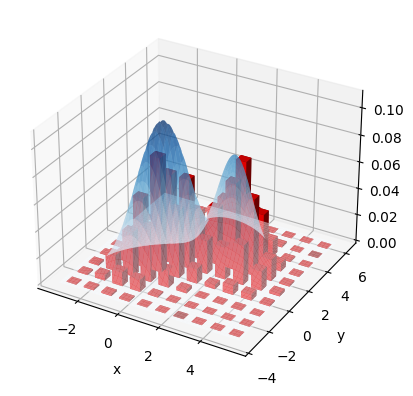

In [9]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t)

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=10000)
random_keys = jax.random.split(random_key, 10000)

ula_wrapped = partial(ula, learned_score_fn, T=10, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

plot_histogram(samples[:,0], samples[:,1])
plt.show()

### Test sliced score matching

In [3]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*3, dim=2)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, samples[0], 0)
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(model_param)

sliced_score_matching_loss_wrapped = partial(sliced_score_matching_loss, model.apply)

In [4]:
@jax.jit
def params_update(param, optimizer_state, xs, random_key):
    ts = jnp.zeros(xs.shape[0])
    loss, grad = jax.value_and_grad(sliced_score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for i in range(10000):
    # get a batch of data
    xs = generate_samples_2d(1024)
    random_key, key_to_use = jax.random.split(random_key)
    # one step grad update
    loss, model_param, optimizer_state = params_update(model_param, optimizer_state, xs, key_to_use)
    losses.append(loss)
    if (i+1) % 1000 == 0:
        print(f"iter:{i+1}, loss:{loss}")

iter:1000, loss:-0.9248527884483337
iter:2000, loss:-0.9614598155021667
iter:3000, loss:-1.0336346626281738
iter:4000, loss:-1.1239410638809204
iter:5000, loss:-1.0415096282958984
iter:6000, loss:-1.0445839166641235
iter:7000, loss:-1.305177092552185
iter:8000, loss:-1.2036864757537842
iter:9000, loss:-0.9626363515853882
iter:10000, loss:-1.08466637134552


NameError: name 'expected_loss_lower_bound' is not defined

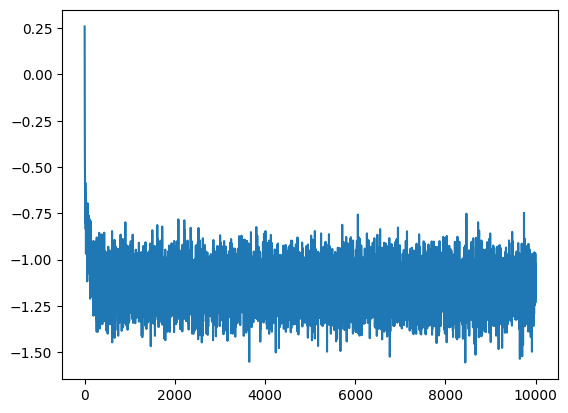

In [5]:
plt.figure()
plt.plot(losses, label="training loss")
plt.plot([expected_loss_lower_bound]*len(losses), label="expected lower bound")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

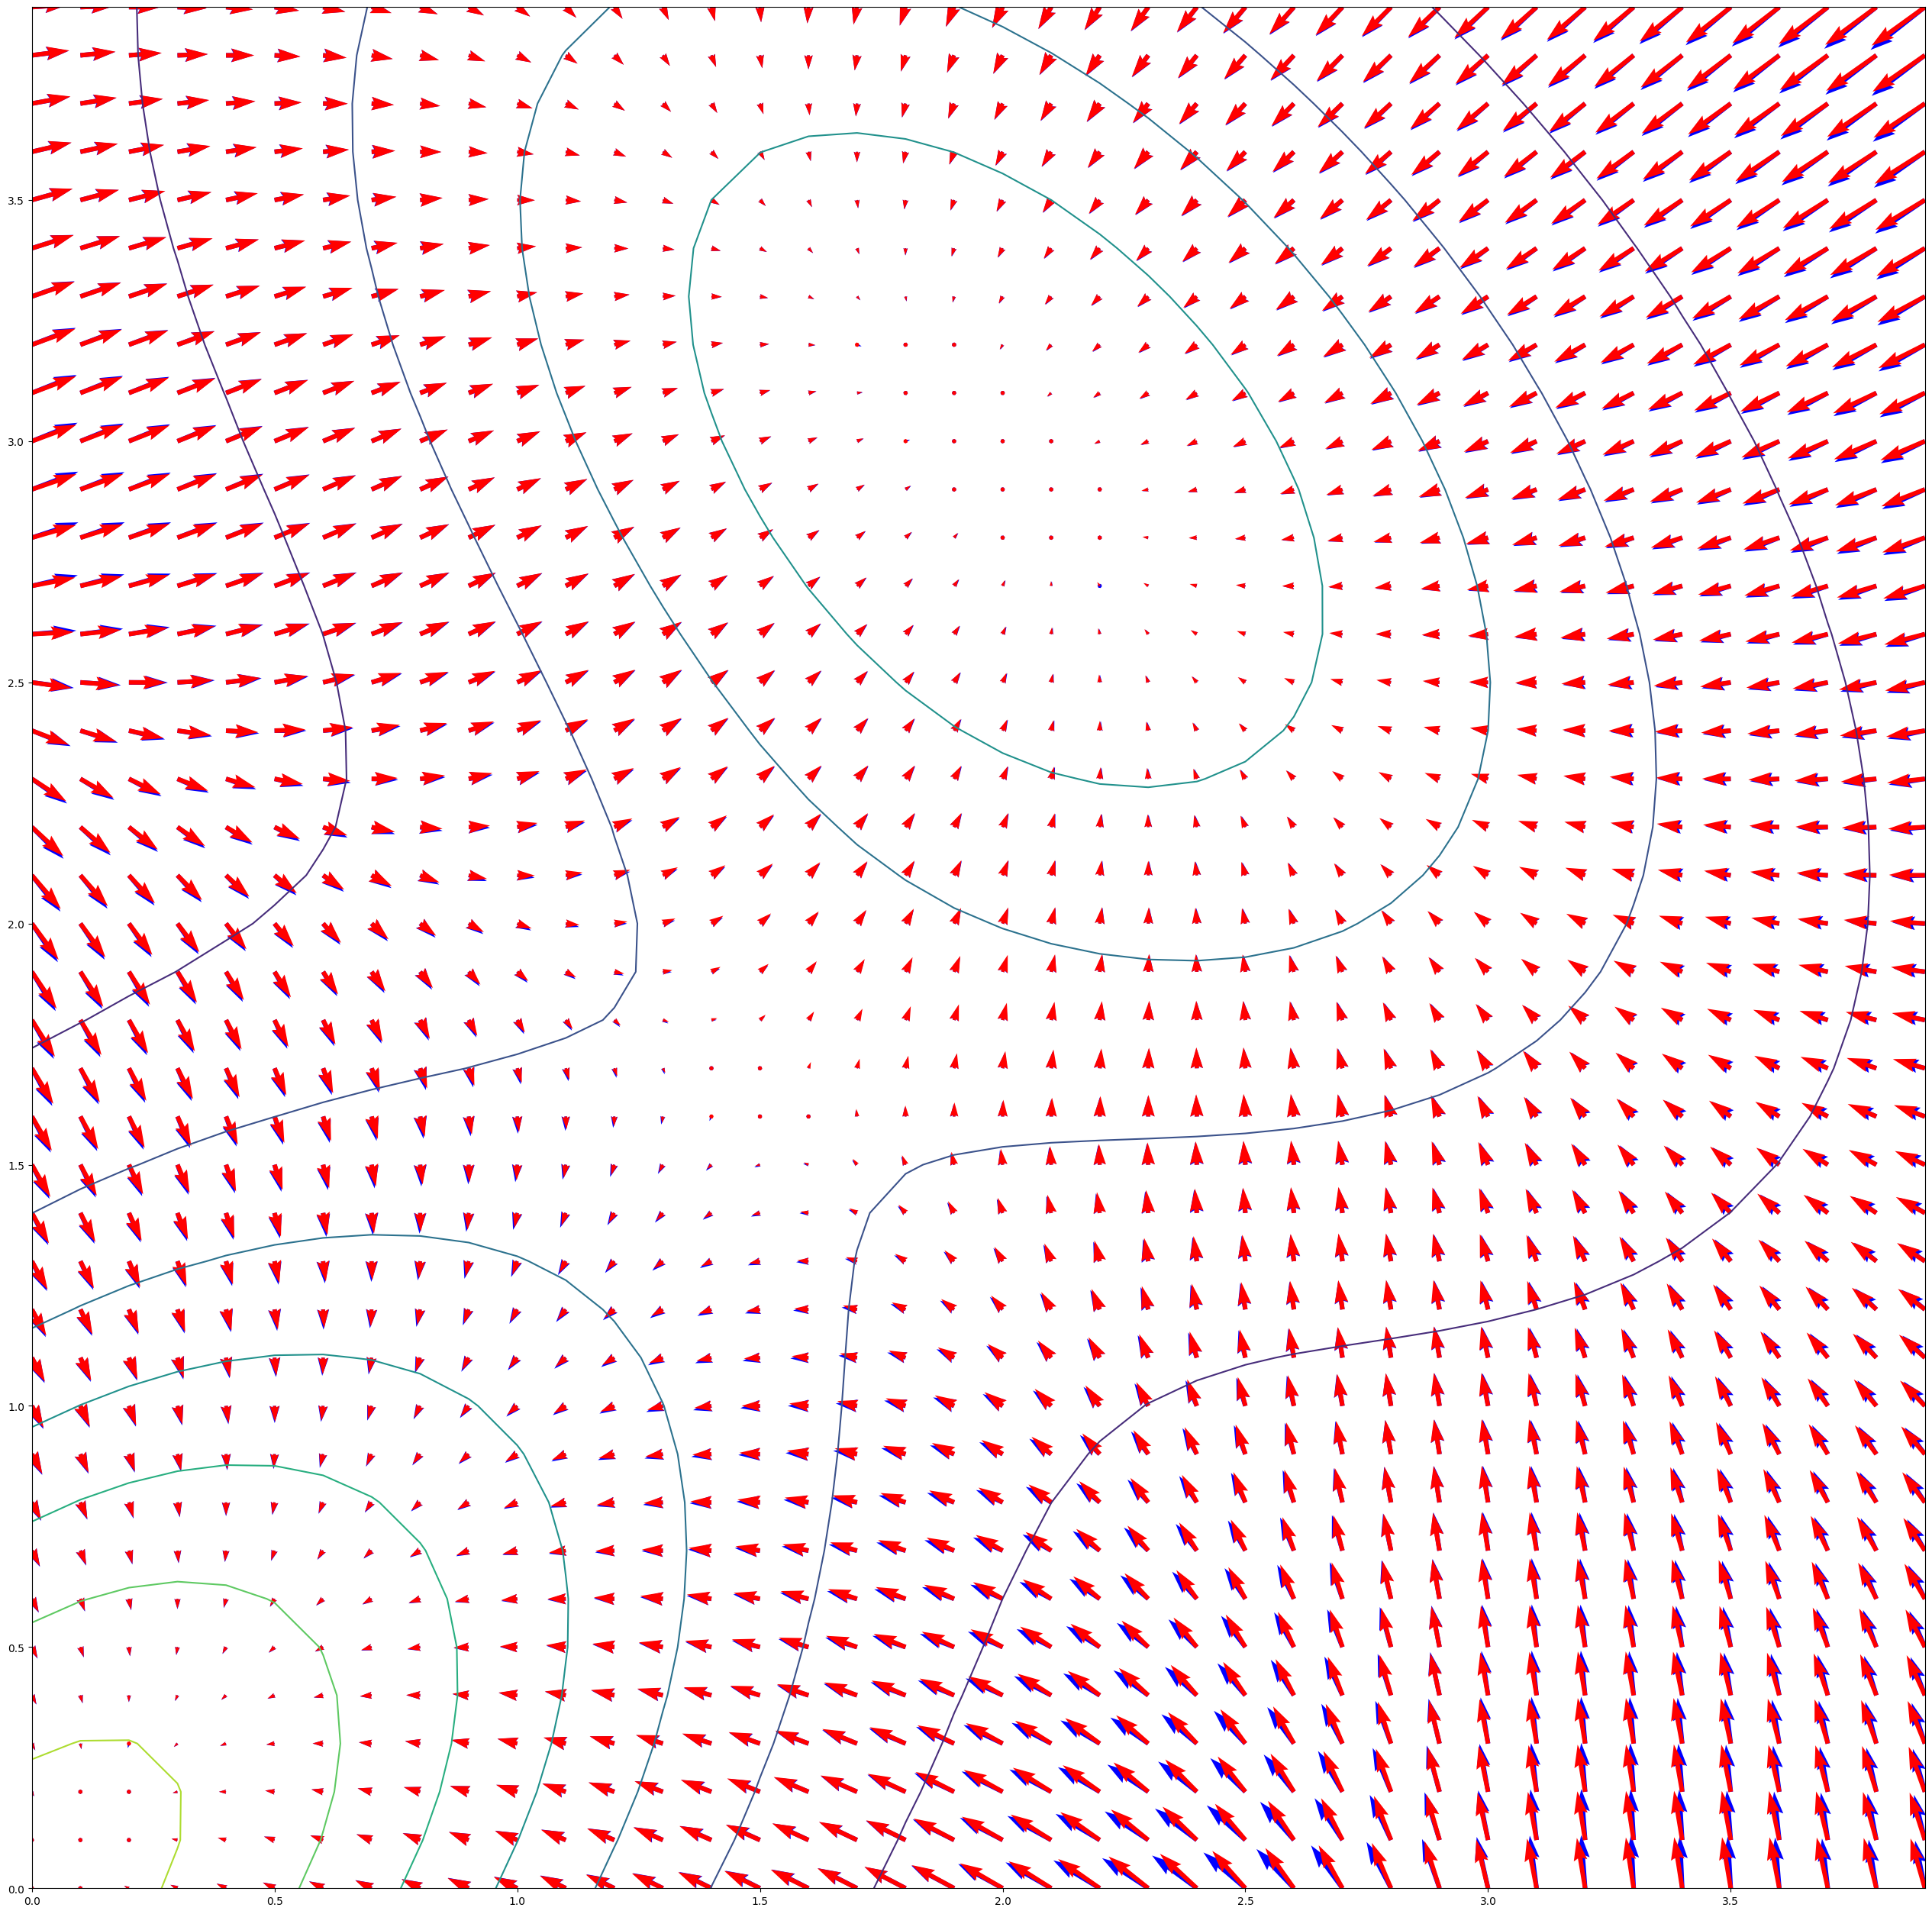

In [6]:
def learned_score_fn(x):
    return model.apply(model_param, x, 0)

plot_score(np.arange(0, 4, 0.1), np.arange(0, 4, 0.1), learned_score_func=learned_score_fn)

### Sliced score experiments speed test

See whether the sliced score matching speed up if we have jax jit.

First test is construct a general function with different dimension. Second case, we test use with neural network.

For neural network sliced score matching is roughly 10 times fast when the dimension is 1024;
For general construct function, sliced score matching is simliar to vanilla when dimension is 1024 and 200 times faster when dimension is 32768

In [7]:
import time

# Test for non-neural model 
# Random score function
def score(x):
    return x - 1/x * x[0] / x[-5] * jnp.exp(x[325])

@jax.jit
def score_jac_trace(x):
    return jnp.trace(jax.jacobian(score)(x))

def sliced_score(x, v):
    return jnp.dot(v, score(x))

@jax.jit
def sliced_score_jac(x, v):
    return jnp.dot(jax.jacobian(sliced_score)(x, v), v)

score_jac_trace_vmap = jax.vmap(score_jac_trace)
sliced_score_jac_vmap = jax.vmap(sliced_score_jac)

xs = np.ones((10, 2**15))
print(score_jac_trace_vmap(xs)[0]*0)
print(sliced_score_jac_vmap(xs, xs)[0] * 0)
start_time = time.time()
print(score_jac_trace_vmap(xs)[0] * 0)
print("time for excute vanilla score matching for 32768 dim", time.time() - start_time)
start_time = time.time()
print(sliced_score_jac_vmap(xs, xs)[0] * 0)
print("time for excute sliced score matching for 32768 dim",time.time() - start_time)

xs = np.ones((10, 1024))
score_jac_trace_vmap(xs)
sliced_score_jac_vmap(xs, xs)
start_time = time.time()
print(score_jac_trace_vmap(xs)[0] * 0)
print("time for excute vanilla score matching for 1024 dim", time.time() - start_time)
start_time = time.time()
print(sliced_score_jac_vmap(xs, xs)[0] * 0)
print("time for excute sliced score matching for 1024 dim",time.time() - start_time)

0.0
0.0
0.0
time for excute vanilla score matching for 32768 dim 0.44364500045776367
0.0
time for excute sliced score matching for 32768 dim 0.0022554397583007812
0.0
time for excute vanilla score matching for 1024 dim 0.001535654067993164
0.0
time for excute sliced score matching for 1024 dim 0.0013289451599121094


In [23]:
# Test for neural model
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*3, dim=1024)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, np.zeros(1024), 0)

score_matching_loss_wrapped = jax.jit(partial(score_matching_loss, model.apply))
sliced_score_matching_loss_wrapped = jax.jit(partial(sliced_score_matching_loss, model.apply))

xs = np.ones((500, 1024))
ts = np.ones(500,)

score_matching_loss_wrapped(model_param, xs, ts)
sliced_score_matching_loss_wrapped(model_param, xs, ts, random_key)
start_time = time.time()
print(score_matching_loss_wrapped(model_param, xs, ts) * 0)
print("time for excute vanilla score matching for 1024 dim", time.time() - start_time)
start_time = time.time()
print(sliced_score_matching_loss_wrapped(model_param, xs, ts, random_key) * 0)
print("time for excute sliced score matching for 1024 dim",time.time() - start_time)

0.0
time for excute sliced score matching for 1024 dim 0.0039014816284179688
0.0
time for excute vanilla score matching for 1024 dim 0.027924299240112305
